Importing the packages

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2 as cv

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the dataset directory

In [17]:
train_dir="/content/drive/MyDrive/Datasets/Animal/final/train/flip"
test_dir="/content/drive/MyDrive/Datasets/Animal/final/test/flip"

In [18]:
class_names=['BUMPS','HAIR LOSS','HOT SPOTS','RASHES','SORES']

Generating the Dataset to input it as the model

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen= ImageDataGenerator()
test_datagen= ImageDataGenerator()
train_gen=train_datagen.flow_from_directory(train_dir,target_size=(128,128),batch_size=3)
val_gen=test_datagen.flow_from_directory(test_dir,target_size=(128,128),batch_size=1)

Found 469 images belonging to 5 classes.
Found 101 images belonging to 5 classes.


Importing the packages for creating the cnn model

In [20]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D

Without tuning

In [21]:
model=Sequential()

model.add(Conv2D(input_shape=(128,128,3), filters=64,kernel_size=(3,3), padding="same",activation='relu',use_bias=True))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu',use_bias=True, kernel_regularizer =tf.keras.regularizers.l2( l=0.001)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu',use_bias=True, kernel_regularizer =tf.keras.regularizers.l2( l=0.001)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu',use_bias=True, kernel_regularizer =tf.keras.regularizers.l2( l=0.001)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu',use_bias=True, kernel_regularizer =tf.keras.regularizers.l2( l=0.001)))
model.add(MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(32,activation='relu'))
#model.add(layers.Dense(64,activation='relu'))
#model.add(layers.Dense(32,activation='relu'))
#model.add(layers.Dense(64,activation='relu'))
#model.add(layers.Dense(128,activation='relu'))
#model.add(layers.Dense(256,activation='relu'))
#model.add(layers.Dense(128,activation='relu'))
#model.add(layers.Dense(64,activation='relu'))
#model.add(layers.Dense(32,activation='relu'))
#model.add(layers.Dense(64,activation='relu'))
#model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(5,activation='softmax'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)      

Compiling the model


In [23]:
from tensorflow.keras import optimizers
#from keras.optimizers import Adam
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['acc'])

In [24]:
checkpoint_cb= keras.callbacks.ModelCheckpoint("Bestmodel.h5",save_best_only=True)

In [25]:
early_stop=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [26]:
model_history=model.fit(train_gen,steps_per_epoch=30,epochs=100,validation_data=val_gen,validation_steps=15,callbacks=[checkpoint_cb])

Epoch 1/100
30/30 [==============================] - 79s 2s/step - loss: 2.7855 - acc: 0.2778 - val_loss: 2.2861 - val_acc: 0.2000
Epoch 2/100
30/30 [==============================] - 55s 2s/step - loss: 2.0976 - acc: 0.2444 - val_loss: 2.0333 - val_acc: 0.4000
Epoch 3/100
30/30 [==============================] - 52s 2s/step - loss: 1.8921 - acc: 0.2889 - val_loss: 1.8857 - val_acc: 0.2667
Epoch 4/100
30/30 [==============================] - 35s 1s/step - loss: 1.8734 - acc: 0.3000 - val_loss: 2.0097 - val_acc: 0.0000e+00
Epoch 5/100
30/30 [==============================] - 30s 1s/step - loss: 1.7977 - acc: 0.3111 - val_loss: 2.5108 - val_acc: 0.0667
Epoch 6/100
30/30 [==============================] - 26s 885ms/step - loss: 1.7260 - acc: 0.3182 - val_loss: 2.1247 - val_acc: 0.3333
Epoch 7/100
30/30 [==============================] - 17s 590ms/step - loss: 1.7383 - acc: 0.2889 - val_loss: 2.1650 - val_acc: 0.0667
Epoch 8/100
30/30 [==============================] - 17s 541ms/step - los

(0.0, 1.0)

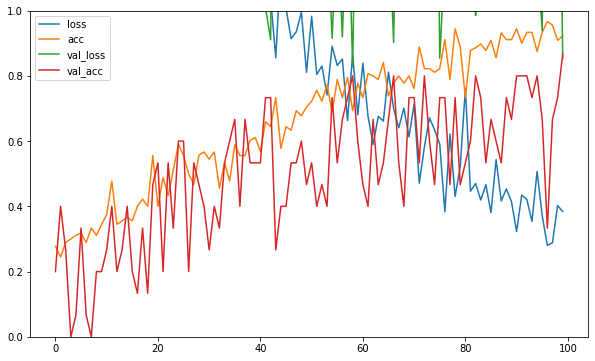

In [27]:
pd.DataFrame(model_history.history).plot(figsize=[10,6])
plt.gca().set_ylim(0,1)

Tuning

In [28]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 26.1 MB/s 
     |████████████████████████████████| 1.6 MB 60.5 MB/s 


In [29]:
def build_model(param):

  model = Sequential()
  model.add(Conv2D(input_shape=(128, 128, 3), filters=param.Int('conv_0_filter', min_value=16, max_value=64, step=16),kernel_size=param.Choice('conv_0_kernel', values = [3,5]), padding=param.Choice('conv_0_padding',['same','valid']),activation=param.Choice('conv_0_activation',['tanh','relu']),use_bias=True))
  model.add(Conv2D(filters=param.Int('conv_1_filter', min_value=16, max_value=64, step=16),kernel_size=param.Choice('conv_1_kernel', values = [3,5]), padding="same",activation='relu',use_bias=True))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D( filters=param.Int('conv_2_filter', min_value=16, max_value=64, step=16),kernel_size=param.Choice('conv_2_kernel', values = [3,5]), activation=param.Choice('conv_2_activation',['tanh','relu']),use_bias=True))
  model.add(MaxPooling2D((2, 2)))
  

  model.add(Conv2D( filters=param.Int('conv_3_filter', min_value=16, max_value=64, step=16),kernel_size=param.Choice('conv_3_kernel', values = [3,5]),activation=param.Choice('conv_3_activation',['tanh','relu']),use_bias=True))
  model.add(MaxPooling2D((2, 2)))
  

  model.add(Conv2D(filters=param.Int('conv_4_filter', min_value=16, max_value=64, step=16),kernel_size=param.Choice('conv_4_kernel', values = [1,3]),activation=param.Choice('conv_4_activation',['tanh','relu']),use_bias=True))
  model.add(MaxPooling2D((2, 2)))


  model.add(Conv2D(filters=param.Int('conv_5_filter', min_value=16, max_value=64, step=16),kernel_size=param.Choice('conv_5_kernel', values = [1,3]),activation=param.Choice('conv_5_activation',['tanh','relu']),use_bias=True))
  model.add(MaxPooling2D((2, 2)))


  model.add(layers.Flatten())
  model.add(layers.Dense(units=param.Int('dense_1_units', min_value=16, max_value=64, step=16), activation='relu'))
  model.add(layers.Dense(units=param.Int('dense_2_units', min_value=16, max_value=64, step=16), activation='relu'))

  model.add(layers.Dense(units=param.Int('dense_3_units', min_value=16, max_value=64, step=16), activation='relu'))
  model.add(layers.Dense(units=param.Int('dense_4_units', min_value=16, max_value=64, step=16), activation='relu'))

  model.add(layers.Dropout(rate=0.3))
  model.add(layers.Dense(5,activation='softmax'))
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
  
  return model


In [30]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [32]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy'
                          max_trials=10)

In [33]:
tuner_search.search(train_gen,validation_data = val_gen,epochs=30,)

Trial 10 Complete [00h 01m 09s]
val_accuracy: 0.2970297038555145

Best val_accuracy So Far: 0.2970297038555145
Total elapsed time: 00h 11m 39s


In [34]:
model1=tuner_search.get_best_models(num_models=1)[0]

In [35]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 48)        3

In [36]:
model1_history=model1.fit(train_gen,steps_per_epoch=30,epochs=100,validation_data=val_gen,validation_steps=15,callbacks=[checkpoint_cb])

Epoch 1/100
30/30 [==============================] - 1s 20ms/step - loss: 1.5693 - accuracy: 0.2889 - val_loss: 1.7442 - val_accuracy: 0.0667
Epoch 2/100
30/30 [==============================] - 0s 13ms/step - loss: 1.4708 - accuracy: 0.4205 - val_loss: 1.7644 - val_accuracy: 0.0667
Epoch 3/100
30/30 [==============================] - 0s 13ms/step - loss: 1.5143 - accuracy: 0.3333 - val_loss: 1.7307 - val_accuracy: 0.2000
Epoch 4/100
30/30 [==============================] - 0s 15ms/step - loss: 1.5461 - accuracy: 0.3111 - val_loss: 1.7077 - val_accuracy: 0.0000e+00
Epoch 5/100
30/30 [==============================] - 0s 13ms/step - loss: 1.5008 - accuracy: 0.3750 - val_loss: 1.7872 - val_accuracy: 0.1333
Epoch 6/100
30/30 [==============================] - 0s 13ms/step - loss: 1.4876 - accuracy: 0.3750 - val_loss: 1.9063 - val_accuracy: 0.0000e+00
Epoch 7/100
30/30 [==============================] - 0s 14ms/step - loss: 1.5211 - accuracy: 0.3111 - val_loss: 1.7466 - val_accuracy: 0.200

(0.0, 1.0)

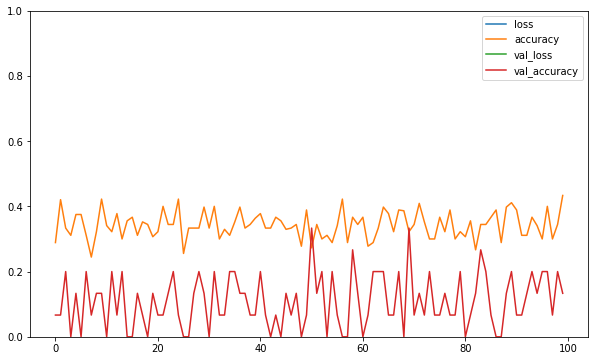

In [37]:
pd.DataFrame(model1_history.history).plot(figsize=[10,6])
plt.gca().set_ylim(0,1)

Testing for an output

In [38]:
image = cv.imread('/content/img2.jpg')

In [39]:
image.shape

(194, 259, 3)

In [40]:
from google.colab.patches import cv2_imshow

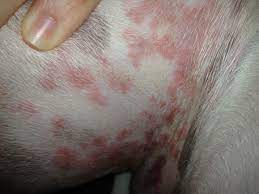

In [41]:
cv2_imshow(image)

Resizing the user given input

In [42]:
def crop_resize(img):
  image_1_resize = cv.resize(img,(128,128))
  return image_1_resize

In [43]:
image=crop_resize(image)
image.shape

(128, 128, 3)

Expanding the dimensions to fit the model

In [44]:
image = tf.expand_dims(image, axis=0)
image.shape.as_list()


[1, 128, 128, 3]

In [45]:
yproba = model.predict(image)
yproba

1/1 [==============================] - 0s 127ms/step


array([[0.6368811 , 0.16866526, 0.02410435, 0.15844354, 0.0119057 ]],
      dtype=float32)

Predicting the class

In [46]:
class_name=class_names[np.argmax(yproba,axis=1)[0]]

In [47]:
class_name

'BUMPS'